# Task 1 : Set up colab gpu runtime environment

In [28]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt



# Some Common Imports

In [29]:
import sys
#sys.path.append('oilspill')

In [30]:
!pip install helper

In [31]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [35]:
csv_file = './imagepath.csv'


device = 'mps'
epochs = 10
lr = 0.03
IMG_SIZE = 320
BATCH_SIZE = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'


In [36]:
df = pd.read_csv(csv_file)
df.head()

,image,mask
0,./image/img10.jpg,./mask/img10.jpg
1,./image/img100.jpg,./mask/img100.jpg
2,./image/img101.jpg,./mask/img101.jpg
3,./image/img102.jpg,./mask/img102.jpg
4,./image/img103.jpg,./mask/img103.jpg


In [37]:
import pandas as pd

# Assuming you have a DataFrame called "df"

row = df.iloc[5]  # Access the 5th row

image_path = row['image']  # Access the 'image' column value
mask_path = row['mask']  # Access the 'mask' column value

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  /255.0



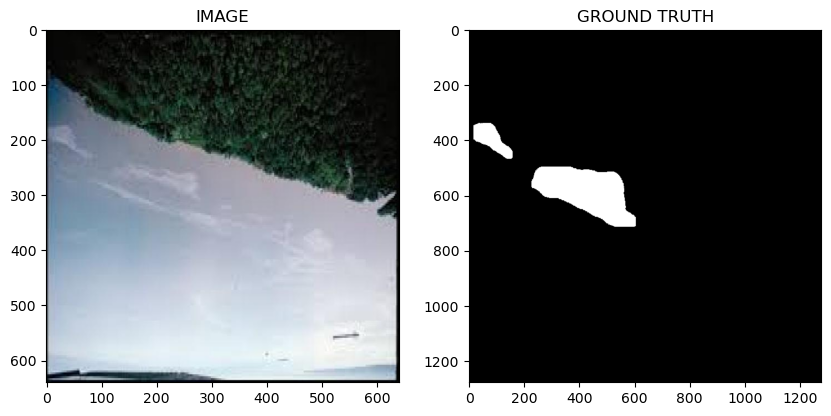

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [62]:
train_df, test= train_test_split(df, test_size = 0.2 , random_state = 42 )



# Split the temporary set equally into validation and test sets
valid_df, test_df  = train_test_split(test, test_size=0.5, random_state=42)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [63]:
import albumentations as A

In [64]:
def get_train_augs():
    return A.Compose([
        A.Resize(height=256, width=256),
        # Add other augmentations here

      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs() :
   return A.Compose([
        A.Resize(height=256, width=256),
        # Add other augmentations here


  ], is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [65]:
from torch.utils.data import Dataset

In [66]:
class SegmentationDataset (Dataset) :

  def __init__(self , df, augmentations) :
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)


  def __getitem__(self,idx) :

    row = self.df.iloc[idx]
    image_path = row['image']  # Access the 'image' column value
    mask_path = row['mask']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask= np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask )
      image = data['image']
      mask= data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) /255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask
      


In [67]:
trainset = SegmentationDataset(train_df,get_train_augs())
testset= SegmentationDataset(test_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [76]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")
print(f"size of testset : {len(testset)}")

Size of Trainset : 310
Size of Validset : 39
size of testset : 39


Text(0.5, 1.0, 'Ground Truth Mask')

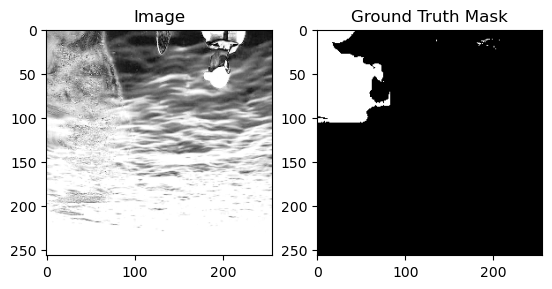

In [77]:
idx = 6
image, mask = trainset[6]
plt.subplot(1, 2, 1)
plt.imshow(image[0].cpu().numpy(), cmap='gray')
plt.title('Image')


plt.subplot(1, 2, 2)
plt.imshow(mask[0].cpu().numpy(), cmap='gray')
plt.title('Ground Truth Mask')

# Task 5 : Load dataset into batches

In [78]:
from torch.utils.data import DataLoader


In [79]:
trainloader =  DataLoader(trainset,batch_size=BATCH_SIZE , shuffle = True )
validloader = DataLoader(validset,batch_size = BATCH_SIZE)

In [80]:
print(f"total no of batches in trainloader : {len(trainloader)}")
print(f"total no of batches in validloader : {len(validloader)}")

total no of batches in trainloader : 20
total no of batches in validloader : 3


In [81]:
for image , mask in trainloader :
  break

print(f"one batch image shape : {image.shape}")
print(f"one batch imask shape : {mask.shape}")

one batch image shape : torch.Size([16, 3, 256, 256])
one batch imask shape : torch.Size([16, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [82]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [83]:
class SegmentationModel(nn.Module):

  def __init__(self):

    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder ,
        encoder_weights=  weights ,
        in_channels = 3 ,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks = None):
    logits = self.arc(images)
    if masks !=None:
      loss1= DiceLoss(mode='binary')(logits,masks)
      loss2= nn.BCEWithLogitsLoss()(logits,masks)

      return logits,loss1+loss2
    return logits

In [84]:
model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [85]:
def train_fn(data_loader , model , optimizer):
  model.train()
  total_loss = 0.0
  for images , masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logit, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/ len(data_loader)

In [86]:
def eval_fn(data_loader , model ):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images , masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logit, loss = model(images, masks)



      total_loss += loss.item()

    return total_loss/ len(data_loader)



# Task 8 : Train Model

In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr= lr)


In [88]:
best_valid_loss = np.Inf
for i in range (epochs):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), './best_model.pt')
    print("saved model")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss: {valid_loss}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


saved model
Epoch : 1 Train_loss : 1.2115164041519164 Valid_loss: 3.326552152633667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.84it/s]


saved model
Epoch : 2 Train_loss : 1.1352041810750961 Valid_loss: 1.7662022113800049


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.19it/s]


saved model
Epoch : 3 Train_loss : 1.0929729104042054 Valid_loss: 1.3045617739359539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.91it/s]


Epoch : 4 Train_loss : 1.0943840563297271 Valid_loss: 3.574706236521403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.06it/s]


saved model
Epoch : 5 Train_loss : 1.135126268863678 Valid_loss: 1.2124643325805664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.40it/s]


saved model
Epoch : 6 Train_loss : 1.092354851961136 Valid_loss: 1.179846962292989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.21it/s]


saved model
Epoch : 7 Train_loss : 1.0615924000740051 Valid_loss: 1.1574285626411438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.02it/s]


saved model
Epoch : 8 Train_loss : 1.0356015533208847 Valid_loss: 1.073306639989217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.29it/s]


saved model
Epoch : 9 Train_loss : 0.9785026013851166 Valid_loss: 1.0154436628023784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.77it/s]

Epoch : 10 Train_loss : 1.0274002254009247 Valid_loss: 1.5743611256281536


# Task 9 : Inference

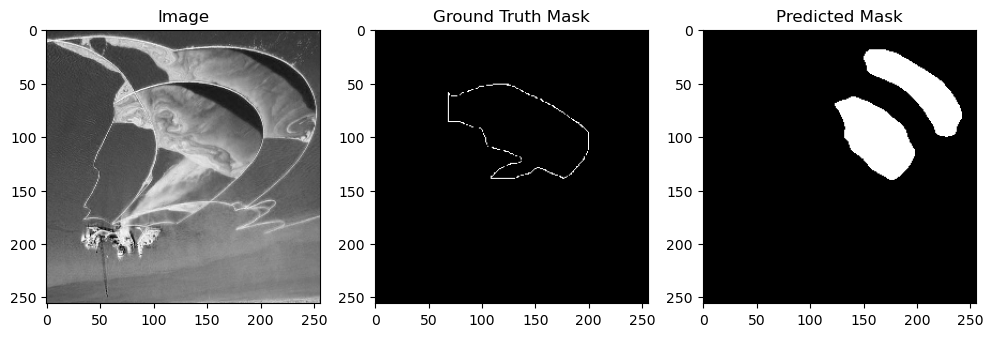

In [90]:
import matplotlib.pyplot as plt

idx = 5

# Load the model state
model.load_state_dict(torch.load('./best_model.pt'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Get the image and ground truth mask
image, mask = testset[idx]

# Convert the image to the same device as the model
image = image.to(device)

# Make a prediction with the model
with torch.no_grad():
    logits_mask = model(image.unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5).float()  # Apply threshold for binary mask

# Plot the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(image[0].cpu().numpy(), cmap='gray')
plt.title('Image')

# Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(mask[0].cpu().numpy(), cmap='gray')
plt.title('Ground Truth Mask')

# Plot the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask[0, 0].cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()


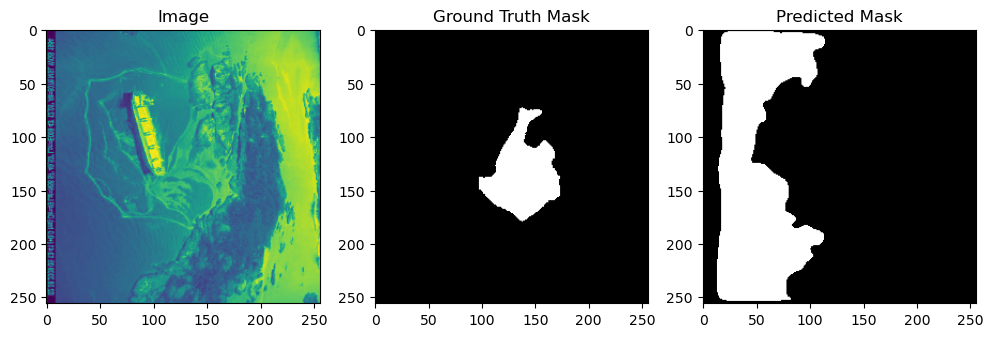

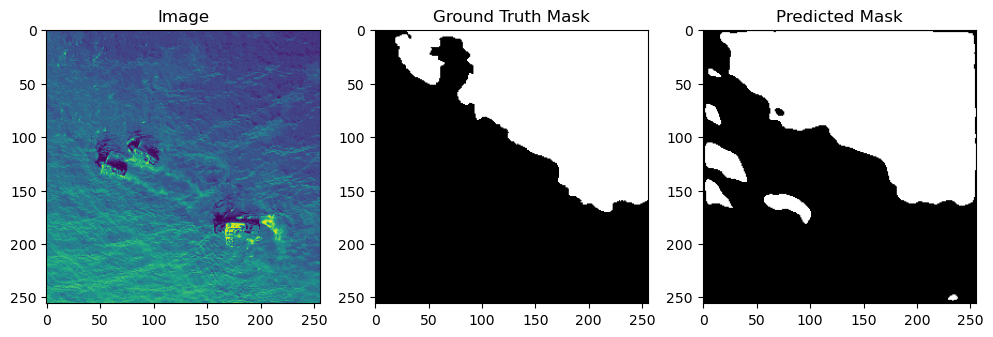

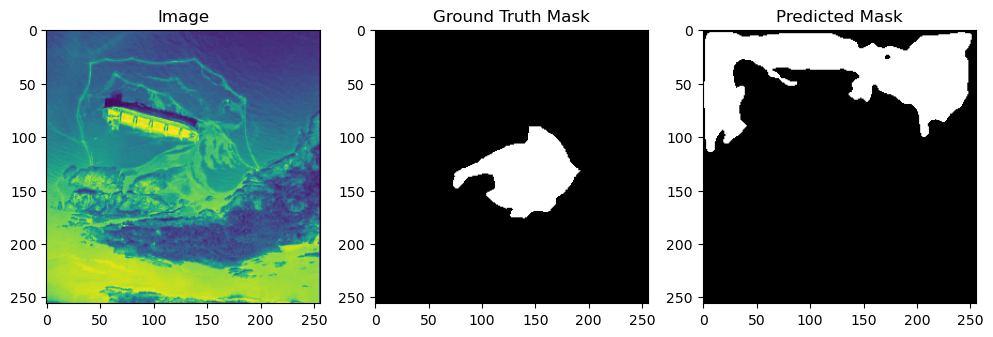

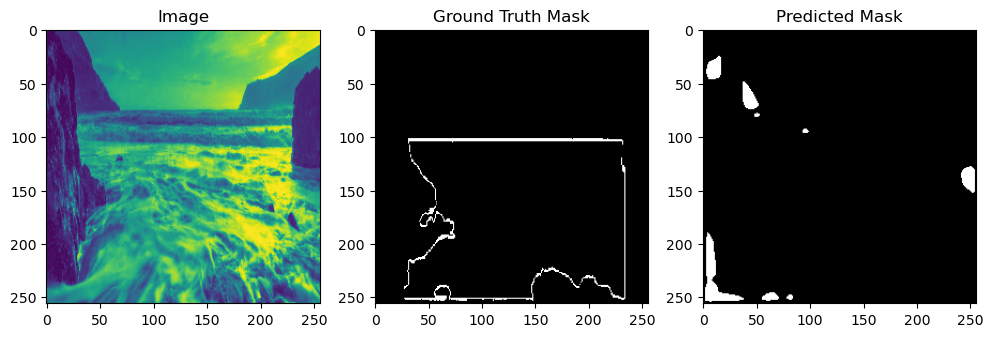

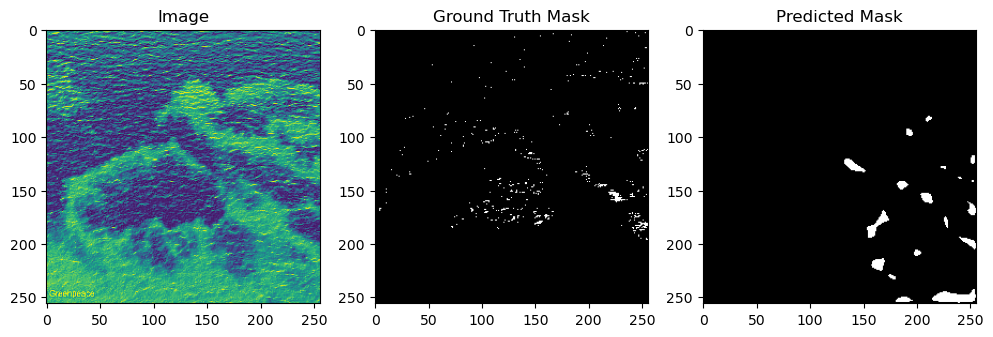

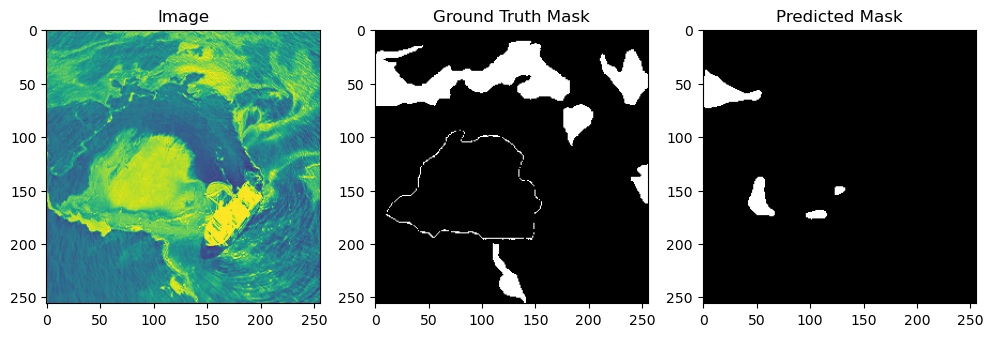

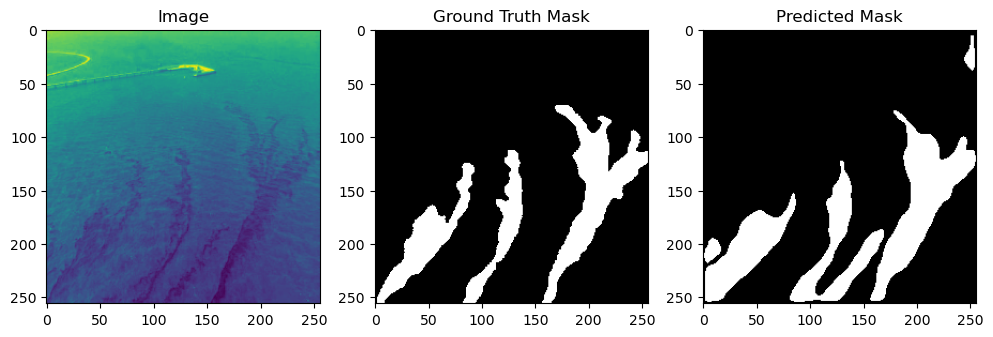

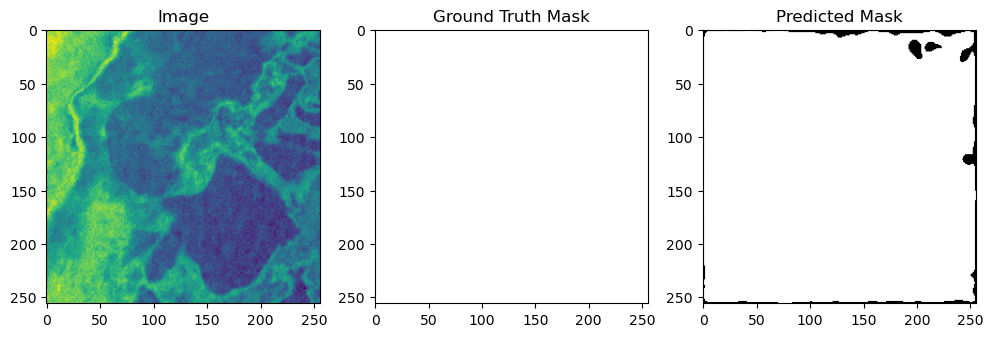

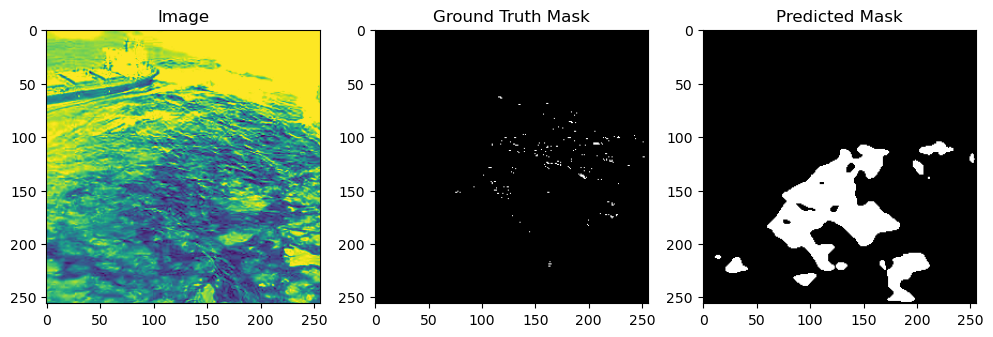

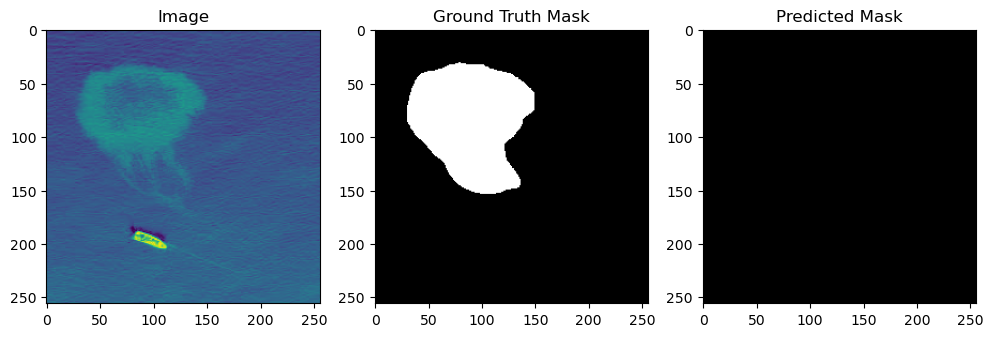

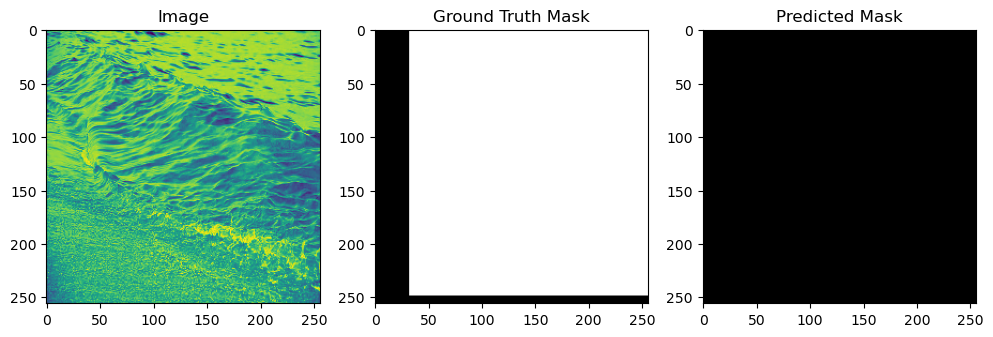

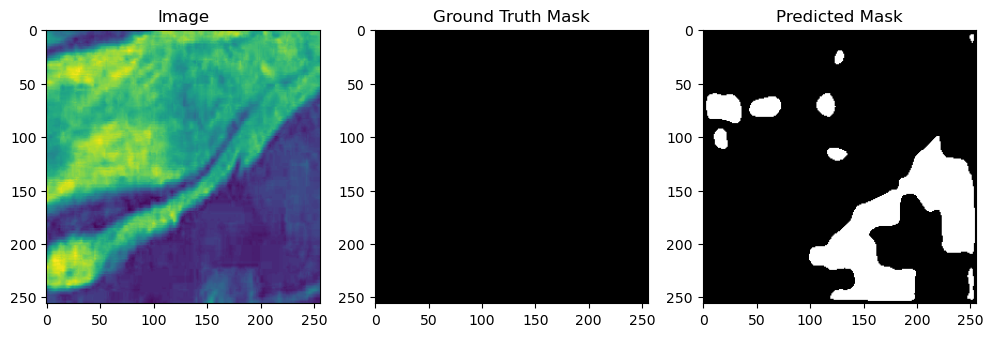

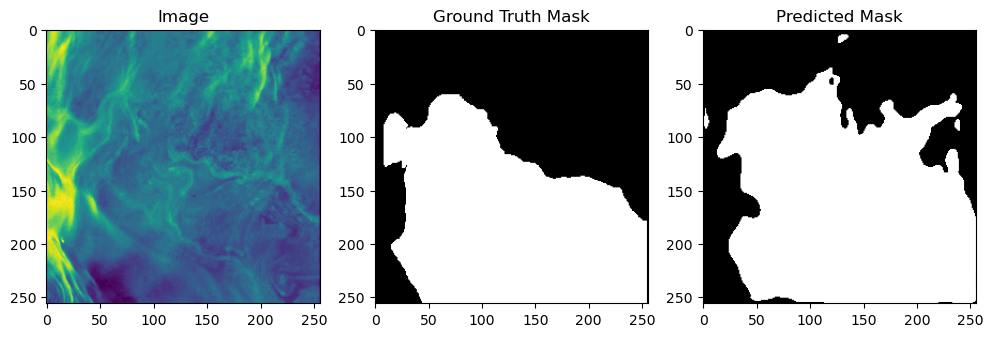

In [59]:
import matplotlib.pyplot as plt



# Load the model state
model.load_state_dict(torch.load('./best_model.pt'))
model.to(device)
model.eval()  # Set the model to evaluation mode
for idx in range(1,14):
    image, mask = testset[idx]

# Convert the image to the same device as the model
    image = image.to(device)

# Make a prediction with the model
    with torch.no_grad():
        logits_mask = model(image.unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > 0.5).float()  # Apply threshold for binary mask

# Plot the original image, ground truth mask, and predicted mask
    plt.figure(figsize=(12, 4))

# Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].cpu().numpy())
    plt.title('Image')

# Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].cpu().numpy(), cmap='gray')
    plt.title('Ground Truth Mask')

# Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[0, 0].cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

In [91]:
def accuracy(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()  # Assuming 0.5 as the threshold for binary classification
    correct = (y_pred == y_true).sum().item()
    total = y_true.numel()  # Total number of elements in y_true
    return correct / total

Mean Accuracy: 0.77


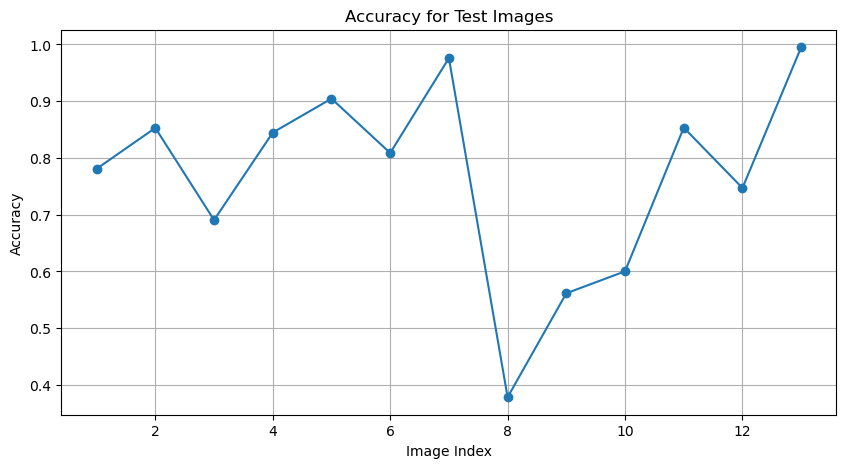

In [92]:
accuracy_values = []

for idx in range(1, 14):
    image, mask = testset[idx]

    # Convert the image to the same device as the model
    image = image.to(device)
    mask = mask.to(device)

    # Make a prediction with the model
    with torch.no_grad():
        logits_mask = model(image.unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > 0.6).float()

    # Calculate accuracy and append it to the list
    acc = accuracy(pred_mask, mask)
    accuracy_values.append(acc)
mean_accuracy = sum(accuracy_values) / len(accuracy_values)
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Plot the accuracy values
plt.figure(figsize=(10, 5))
plt.plot(range(1, 14), accuracy_values, marker='o')
plt.title("Accuracy for Test Images")
plt.xlabel("Image Index")
plt.ylabel("Accuracy")
plt.grid()
plt.show()